In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile
from keras.regularizers import l1,l2

In [4]:
dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 202599 files belonging to 1 classes.


2023-04-13 23:12:12.150642: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


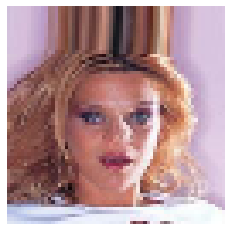

In [5]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    
    plt.savefig('dataset_image.png')
    break

In [6]:
# discriminator = keras.Sequential(
#     [
#         keras.Input(shape=(64, 64, 3)),
#         layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Flatten(),
#         layers.Dropout(0.2),
#         layers.Dense(1, activation="sigmoid"),
#     ],
#     name="discriminator",
# )


# With L2 Regularization
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid", kernel_regularizer=l1(0.01)),
    ],
    name="discriminator",
)

In [7]:
with open('discriminator_summary.txt', 'w') as f:

    discriminator.summary(print_fn=lambda x: f.write(x + '\n'))

In [8]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [9]:
with open('generator_summary.txt', 'w') as f:

    generator.summary(print_fn=lambda x: f.write(x + '\n'))

In [10]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [11]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
        img.save("generated_img_%03d_%d.png" % (epoch, i))
        

In [12]:
epochs = 15  # In practice, use ~100 epochs
from keras.callbacks import EarlyStopping
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = gan.fit(
    dataset, epochs=epochs, 
    callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim), early_stopping]
)

Epoch 1/15


2023-04-13 23:12:17.526088: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2023-04-13 23:12:17.933083: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-13 23:12:17.933443: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-13 23:12:17.933458: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2023-04-13 23:12:17.933824: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-13 23:12:17.933865: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


6332/6332 [==============================] - 538s 84ms/step - d_loss: 1093212160.0000 - g_loss: 83871113216.0000
Epoch 2/15
6332/6332 [==============================] - 533s 84ms/step - d_loss: 247419920.0000 - g_loss: 15477258240.0000
Epoch 3/15
6332/6332 [==============================] - 531s 84ms/step - d_loss: -24926799872.0000 - g_loss: 2365595582464.0000
Epoch 4/15
6332/6332 [==============================] - 531s 84ms/step - d_loss: -92353232896.0000 - g_loss: 9933614481408.0000
Epoch 5/15
6332/6332 [==============================] - 531s 84ms/step - d_loss: -155628929024.0000 - g_loss: 19853190627328.0000
Epoch 6/15
6332/6332 [==============================] - 532s 84ms/step - d_loss: -445772431360.0000 - g_loss: 43150617870336.0000
Epoch 7/15
6332/6332 [==============================] - 530s 84ms/step - d_loss: -1121309949952.0000 - g_loss: 113160006664192.0000
Epoch 8/15
6332/6332 [==============================] - 529s 84ms/step - d_loss: -1154592931840.0000 - g_loss: 13247

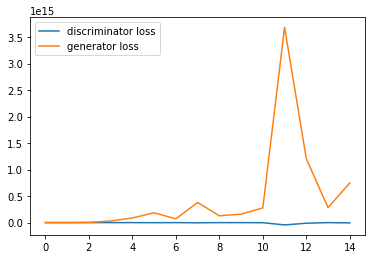

In [12]:
plt.plot(history.history['d_loss'], label='discriminator loss')
plt.plot(history.history['g_loss'], label='generator loss')
plt.legend()
plt.savefig('loss_plot.png')
# plt.show()